## Remapped force constants

In [1]:
import numpy as np
import scipy.linalg as la
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from ase.io import read

from hilde.trajectory import reader
from hilde.harmonic_analysis.displacements import get_dR

from hilde.harmonic_analysis.force_constants import parse_tdep_forceconstant

In [2]:
fc = parse_tdep_forceconstant('outfile.forceconstant_remapped')
primitive = read('infile.ucposcar', format='vasp')
supercell = read('infile.ssposcar', format='vasp')

trajectory = reader('trajectory.yaml.600')

Parse force constants from
  outfile.forceconstant_remapped
.. Number of atoms:   120
.. Real space cutoff: 7.595 \AA
.. time elapsed: 0.073s
.. trajectory.yaml.600 parsed in 1.265s


In [3]:
force_shape = trajectory[0].get_forces().shape

forces_dft = np.array([a.get_forces().flatten() for a in trajectory])

forces_harmonic = np.array([-fc @ get_dR(supercell, a).flatten() for a in trajectory])

## R^2

https://en.wikipedia.org/wiki/Coefficient_of_determination#Comparison_with_norm_of_residuals

In [4]:
def R2(f1, f2):
    f1_mean = np.mean(f1, axis=0)
    f2_mean = np.mean(f2, axis=0)
    Sres = (f1 - f2) @ (f1 - f2)
    Stot = (f1 - f1_mean) @ (f1 - f1_mean)
    
    return 1 - Sres / Stot

In [5]:
r2 = R2(forces_harmonic.flatten(), forces_dft.flatten()) * 100
print(f'R^2 = {np.mean(r2):.2f} +/- {np.std(r2):.2f}')

r2 = R2(forces_dft.flatten(), forces_harmonic.flatten()) * 100
print(f'R^2 = {np.mean(r2):.2f} +/- {np.std(r2):.2f}')

R^2 = 30.12 +/- 0.00
R^2 = 59.25 +/- 0.00


# 1D representation

In [6]:
f_dft = forces_dft.copy().reshape([-1, *force_shape])
f_ha = forces_harmonic.copy().reshape([-1, *force_shape])

# normalize forces

# norm = la.norm(f_dft, axis=(1, 2))[:, None, None]
norm = np.sqrt((f_dft**2).sum(axis=(1, 2)).mean())


f_dft /= norm
f_ha /= norm

norm

6.271492334276274

In [7]:
# x, y, z components
for i in range(3):
    print(R2(f_dft[:, :, i].flatten(), f_ha[:, :, i].flatten()))

0.5863362566510306
0.5837573927968198
0.6061723264749395


In [8]:
# per atom
symbols = np.array(supercell.get_chemical_symbols())

labels = ['I', 'Pb', 'Cs']

r2_atoms = []
for nn, sym in enumerate(labels):
    mask = symbols == sym
    r2_atoms.append(R2(f_dft[:, mask, i].flatten(), f_ha[:, mask, i].flatten()))
    
r2_atoms

[0.6262751593746401, 0.6263660214244886, 0.4166308757674354]

In [9]:
def set_label(ax, xlabel, ylabel, rotation=0):
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel, rotation=rotation)
    
def set_square(ax, lim, line=True, **kwargs):
    ax.set_aspect(1)

    lims = [-lim, lim]

    ax.set_xlim(lims)
    ax.set_ylim(lims)

    if line:
        ax.plot(lims, lims, **kwargs)
        
def set_fontsize(ax, fontsize):
    ax.set_xlabel(ax.get_xlabel(), size=fontsize)
    ax.set_ylabel(ax.get_ylabel(), size=fontsize, rotation=0)
    # ax.yaxis.set_label_coords(-.22, .41)
    # ax.legend(ax.legend(), fontsize=fontsize)

    ax.tick_params(labelsize=fontsize-2)

In [10]:
# https://artsexperiments.withgoogle.com/artpalette/colors/363639-dcceb9-a82935-5e755a-e2ad1e
cs = [
    '#363639',
    '#dcceb9',
    '#a82935',
    '#e2ad1e',
    '#5e755a',
]

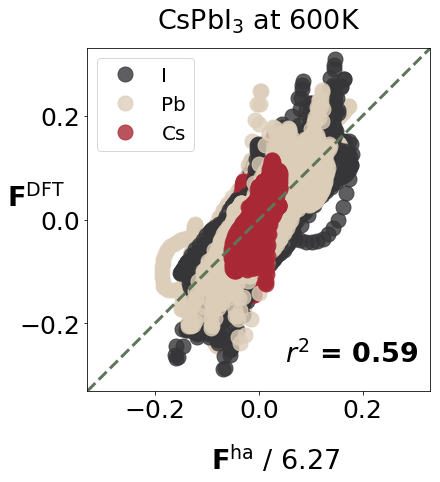

In [11]:
fig, ax = plt.subplots(figsize=(7, 7))

n_steps = 100

ii = 2

symbols = np.array(supercell.get_chemical_symbols())

labels = ['I', 'Pb', 'Cs']

dfs = []
for ii in range(3):
    for nn, sym in enumerate(labels):
        df = pd.DataFrame()
        df[f'x'] = f_ha[:n_steps, symbols == sym, ii].flatten()
        df[f'y'] = f_dft[:n_steps, symbols == sym, ii].flatten()
        dfs.append(df)

        df.plot(x='x', y='y', ax=ax, marker='o', ls='', color=cs[nn], alpha=.8, ms=15)


f_dft_label = '${\mathbf{F}}^{\mathrm{DFT}}$'
f_ha_label = '$\mathbf{F}^{\mathrm{ha}}$ / ' + f'{norm:.2f}' #'  $[\mathrm{eV} / \mathrm{\AA}$]'

set_label(ax, f_ha_label, f_dft_label)
lim = 0.33
set_square(ax, lim, lw=3, ls='--', c=cs[4])

fsize = 27
set_fontsize(ax, fsize)

ax.xaxis.set_label_coords(.55, -.15)
ax.yaxis.set_label_coords(-.15, .52)

ax.set_title('CsPbI$_3$ at 600K', fontsize=fsize, y=1.04)

fig.subplots_adjust(bottom=.2, left=.2)

ax.legend(labels, fontsize=20)

# ax.xaxis.set_ticks(np.arange(-2, 2+.01, 1))
# ax.yaxis.set_ticks(np.arange(-2, 2+.01, 1))

ax.text(0.05, -0.275, f'$r^2$ = {r2/100:.2f}', fontsize=fsize, weight='bold')

fig.savefig('dft_vs_ha_xyz.png', dpi=300)

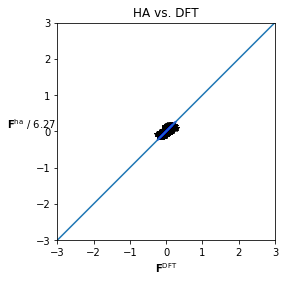

In [12]:
fig, ax = plt.subplots()

y = f_ha[:n_steps, :, 0]
x = f_dft[:n_steps, :, 0]

ax.plot(x, y, '*k')
ax.plot(x, x, 'b')

ax.set_title('HA vs. DFT')

set_square(ax, 3)
set_label(ax, f_dft_label, f_ha_label)